In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [4]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/energy_iiasa_output_data/"

In [6]:
data = pd.read_excel(myfolder+"analysis IIASA august.xlsx","discounted",usecols=range(0,9))

In [7]:
data.columns

Index(['Model', 'Region', 'Scenario', 'Variable', 'Unit', 2015, 2020, 2025,
       2030],
      dtype='object')

In [8]:
data.Variable.unique()

array(['CCS', 'Electricity - Fossil Fuels w/o CCS',
       'Electricity - Non-bio Renewables', 'Electricity - T&D and Storage',
       'Energy Supply|Electricity|Biomass|w/ CCS',
       'Energy Supply|Electricity|Biomass|w/o CCS',
       'Energy Supply|Electricity|Coal|w/ CCS',
       'Energy Supply|Electricity|Coal|w/o CCS',
       'Energy Supply|Electricity|Electricity Storage',
       'Energy Supply|Electricity|Gas|w/ CCS',
       'Energy Supply|Electricity|Gas|w/o CCS',
       'Energy Supply|Electricity|Geothermal',
       'Energy Supply|Electricity|Hydro',
       'Energy Supply|Electricity|Nuclear',
       'Energy Supply|Electricity|Ocean',
       'Energy Supply|Electricity|Oil|w/ CCS',
       'Energy Supply|Electricity|Solar',
       'Energy Supply|Electricity|Transmission and Distribution',
       'Energy Supply|Electricity|Wind', 'Elec_FFwCCS',
       'Elec_nonRen-clean', 'Elec_gen_tot', 'Elec_tot_inv', 'GDP|MER',
       'Population', 'Secondary Energy|Electricity', 'Elec_tot_g

In [9]:
data.Region.unique()

array(['R5ASIA', 'R5LAM', 'R5MAF', 'R5REF', 'World', 'Developing'], dtype=object)

In [10]:
data.loc[data.Variable=="GDP|MER","Unit"].unique()

array(['Billion US$2015/yr'], dtype=object)

In [11]:
data.loc[data.Variable=="Elec_tot_inv","Unit"].unique()

array(['Billion US$2015/yr'], dtype=object)

In [117]:
mydata = data.copy()
mydata = mydata.set_index(['Model', 'Region', 'Scenario', 'Variable']).drop("Unit",axis=1).drop(['World', 'Developing'],level="Region").drop("1.5C",level="Scenario")
mydata.columns.name="year"
mydata = mydata.stack()
mydata.name="value"

In [118]:
mydata = mydata.unstack(['Model', 'Region', 'Scenario', 'Variable']).reindex(range(2015,2031)).interpolate(axis=0).stack(['Model', 'Region', 'Scenario', 'Variable'])

In [164]:
investments = mydata.unstack("Variable")[['Elec_tot_inv','GDP|MER']]

In [165]:
investments["investments_over_gdp"] = investments['Elec_tot_inv']/investments['GDP|MER']

In [166]:
investments = investments.reset_index("year")

In [167]:
d = 0.06
investments["discount_factor"] = (1+d)**(1-(investments.year.astype(int)-2015))

In [168]:
investments = investments.set_index("year",append=True)

In [169]:
investments["investments_discounted"] = investments['Elec_tot_inv']*investments['discount_factor']

In [170]:
urban_share = pd.read_csv(myfolder+"urban_share_ssp2.csv")
urban_share = urban_share.drop(["Model - Scenario","Variable","Unit"],axis=1).set_index("Region")
urban_share.columns.name = "year"
urban_share = urban_share.stack()
urban_share.name = "urban_share"

In [171]:
urban_share = urban_share.reset_index()
urban_share["Region"] = urban_share.Region.str.replace(".","").str.replace("R52","R5")
urban_share["year"] = urban_share.year.astype("int")
urban_share.sample(3)

,Region,year,urban_share
15,R5LAM,2060,89.778
27,R5MAF,2080,70.798
35,R5OECD,2060,88.747


In [172]:
urban_share_interp = urban_share.set_index(["Region","year"]).unstack("Region").reindex(range(2010,2101)).interpolate(axis=0).stack()

In [173]:
investments = investments.reset_index().merge(urban_share_interp.reset_index(),on=["Region","year"],how="left")

In [174]:
investments["investments_urban"] = 1/100*investments['Elec_tot_inv']*investments.urban_share
investments["investments_urban_disc"] = 1/100*investments['investments_discounted']*investments.urban_share

In [175]:
investments = investments[investments.year<2031]

In [176]:
investments = investments.set_index(['Model', 'Region', 'Scenario', 'year'])

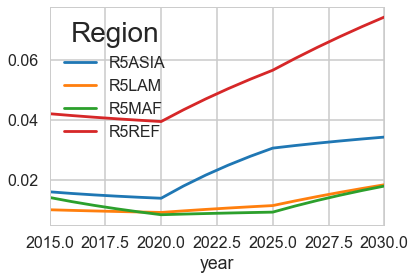

In [177]:
best_scenario = investments.investments_over_gdp.unstack("Scenario")["2C"].unstack("Model")["AIM/CGE"]

best_scenario.unstack("Region").plot()

In [178]:
all_dev_countries = investments.sum(level=["Model", "Scenario","year"]).drop(["investments_over_gdp"],axis=1).copy()

In [179]:
all_dev_countries["investments_over_gdp"] = all_dev_countries['Elec_tot_inv']/all_dev_countries['GDP|MER']
all_dev_countries["investments_over_gdp_urban"] = all_dev_countries['investments_urban']/all_dev_countries['GDP|MER']

In [180]:
1/15*all_dev_countries.investments_discounted.sum(level=["Model", "Scenario"])

Model              Scenario
AIM/CGE            2C          487.147540
                   BAU         296.837209
                   NDC         324.164456
IMAGE              2C          379.638826
                   BAU         423.244419
                   NDC         456.276744
MESSAGEix-GLOBIOM  2C          325.298402
                   BAU         298.659520
                   NDC         304.836756
POLES              2C          503.852684
                   BAU         458.553397
                   NDC         483.852884
REMIND-MAgPIE      2C          759.895756
                   BAU         623.038703
                   NDC         645.230382
WITCH-GLOBIOM      2C          397.358203
                   BAU         423.342544
                   NDC         438.468032
Name: investments_discounted, dtype: float64

In [181]:
1/15*all_dev_countries.investments_urban_disc.sum(level=["Model", "Scenario"])

Model              Scenario
AIM/CGE            2C          263.530758
                   BAU         161.739112
                   NDC         176.999629
IMAGE              2C          192.446908
                   BAU         219.490089
                   NDC         232.040813
MESSAGEix-GLOBIOM  2C          166.018312
                   BAU         152.474703
                   NDC         155.523849
POLES              2C          257.538316
                   BAU         233.934963
                   NDC         246.642627
REMIND-MAgPIE      2C          393.765019
                   BAU         322.003060
                   NDC         333.830973
WITCH-GLOBIOM      2C          213.625524
                   BAU         227.851421
                   NDC         242.780023
Name: investments_urban_disc, dtype: float64

In [182]:
100*all_dev_countries.investments_over_gdp_urban.mean(level=["Model","Scenario"])

Model              Scenario
AIM/CGE            2C          1.175719
                   BAU         0.698169
                   NDC         0.767093
IMAGE              2C          0.641254
                   BAU         0.733182
                   NDC         0.774834
MESSAGEix-GLOBIOM  2C          0.486290
                   BAU         0.446684
                   NDC         0.455542
POLES              2C          1.086173
                   BAU         0.978948
                   NDC         1.036034
REMIND-MAgPIE      2C          1.544251
                   BAU         1.234894
                   NDC         1.285220
WITCH-GLOBIOM      2C          0.880247
                   BAU         0.915925
                   NDC         0.981711
Name: investments_over_gdp_urban, dtype: float64

In [183]:
100*all_dev_countries.investments_over_gdp.mean(level=["Model","Scenario"])

Model              Scenario
AIM/CGE            2C          2.169828
                   BAU         1.279011
                   NDC         1.402218
IMAGE              2C          1.265186
                   BAU         1.413739
                   NDC         1.523479
MESSAGEix-GLOBIOM  2C          0.954170
                   BAU         0.876392
                   NDC         0.894304
POLES              2C          2.117365
                   BAU         1.911780
                   NDC         2.025414
REMIND-MAgPIE      2C          2.971555
                   BAU         2.382810
                   NDC         2.476985
WITCH-GLOBIOM      2C          1.633793
                   BAU         1.698672
                   NDC         1.769644
Name: investments_over_gdp, dtype: float64

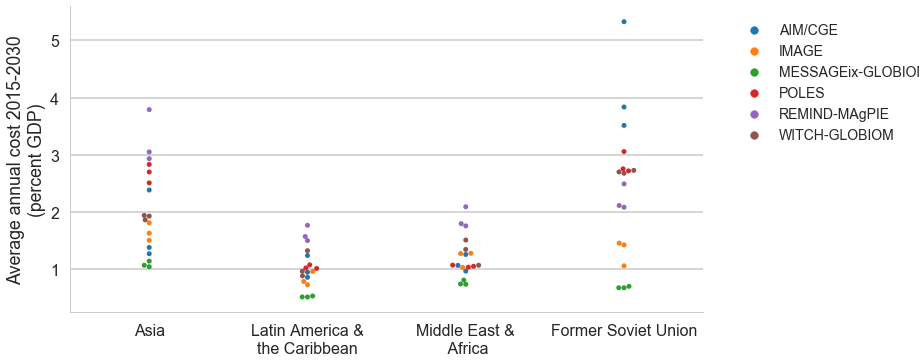

In [100]:
toplot = investments.investments_over_gdp.unstack("year").mean(axis=1).drop("R5OECD90+EU",level="Region")
toplot = toplot.reset_index().rename(columns={0:"investments_over_gdp"})

toplot['investments_over_gdp'] = 100*toplot.investments_over_gdp

toplot["Region"] = toplot.Region.replace({"R5ASIA":"Asia",\
                                         "R5LAM":"Latin America &\nthe Caribbean",\
                                         "R5MAF":"Middle East &\n Africa",\
                                         "R5OECD90+EU":"High income",\
                                         "R5REF":"Former Soviet Union"})

g = sns.factorplot(x='Region',y='investments_over_gdp', data=toplot,hue='Model', kind="swarm",dodge=False, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="",fontsize = 14, bbox_to_anchor=(1, 0.65), borderaxespad=0.)

In [ ]:
all_dev_countries_urban = all_dev_countries.reset_index().merge(urban_share_interp.reset_index(),on=["Region","year"],how="left")

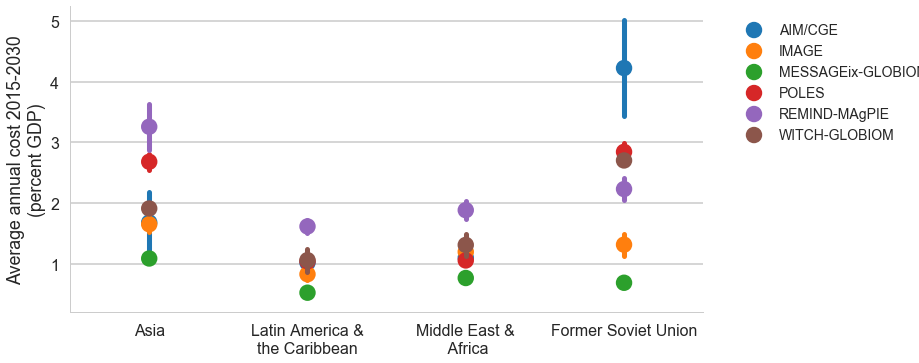

In [101]:
toplot = investments.investments_over_gdp.unstack("year").mean(axis=1).drop("R5OECD90+EU",level="Region")
toplot = toplot.reset_index().rename(columns={0:"investments_over_gdp"})

toplot['investments_over_gdp'] = 100*toplot.investments_over_gdp

toplot["Region"] = toplot.Region.replace({"R5ASIA":"Asia",\
                                         "R5LAM":"Latin America &\nthe Caribbean",\
                                         "R5MAF":"Middle East &\n Africa",\
                                         "R5OECD90+EU":"High income",\
                                         "R5REF":"Former Soviet Union"})

g = sns.factorplot(x='Region',y='investments_over_gdp', data=toplot,hue='Model', kind="point",dodge=False, join=False, size=6, aspect=1.7,ci="sd",\
                  markers="o",legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="",fontsize = 14, bbox_to_anchor=(1, 0.65), borderaxespad=0.)

In [108]:
forgraph = toplot
forgraph["Scenario"] = forgraph.Scenario.replace({"2C":"S2C"})
forgraph = forgraph.set_index(['Model', 'Region', 'Scenario']).unstack("Model").sort_index(level=["Region","Scenario"]).reset_index()
forgraph["Scenario"] = forgraph.Scenario.replace({"S2C":"2C"})
forgraph["Region"] = forgraph.Region.str.replace("\n"," ")
forgraph.to_csv(myfolder+"regional_graph.csv")

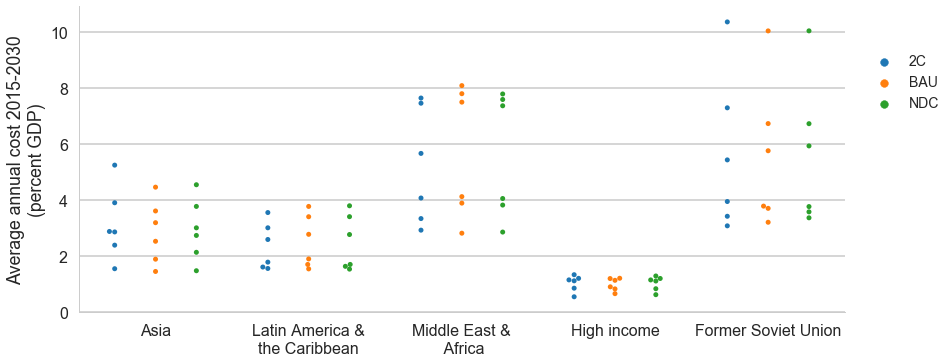

In [62]:
toplot = investments.investments_over_gdp.unstack("year").mean(axis=1)
toplot = toplot.reset_index().rename(columns={0:"investments_over_gdp"})

toplot['investments_over_gdp'] = 100*toplot.investments_over_gdp

toplot["Region"] = toplot.Region.replace({"R5ASIA":"Asia",\
                                         "R5LAM":"Latin America &\nthe Caribbean",\
                                         "R5MAF":"Middle East &\n Africa",\
                                         "R5OECD90+EU":"High income",\
                                         "R5REF":"Former Soviet Union"})

g = sns.factorplot(x='Region',y='investments_over_gdp', data=toplot,hue='Scenario', kind="swarm",dodge=True, size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="",fontsize = 14, bbox_to_anchor=(1, 0.65), borderaxespad=0.)